
📊 DATASET SHIDC – RESUMEN GT (Ki-67)
Total imágenes analizadas        : 700
JSON faltantes                  : 0
Imágenes con 0 Ki-67 anotados   : 20
% sin Ki-67 (sobre total imgs)  : 2.86%

📉 Imágenes con MENOS biomarcadores Ki-67 (pos+neg)
Empate mínimo Ki-67 = 0
Total imágenes empatadas = 20

1. 13037-17_0260_1.jpg | Ki67=0 (Pos=0, Neg=0, TIL=0) | JSON=OK
2. 12655_0310_8.jpg | Ki67=0 (Pos=0, Neg=0, TIL=3) | JSON=OK
3. 3029-96_0130_10.jpg | Ki67=0 (Pos=0, Neg=0, TIL=0) | JSON=OK
4. 15753-17_0050_3.jpg | Ki67=0 (Pos=0, Neg=0, TIL=1) | JSON=OK
5. p-974_0114_8.jpg | Ki67=0 (Pos=0, Neg=0, TIL=0) | JSON=OK


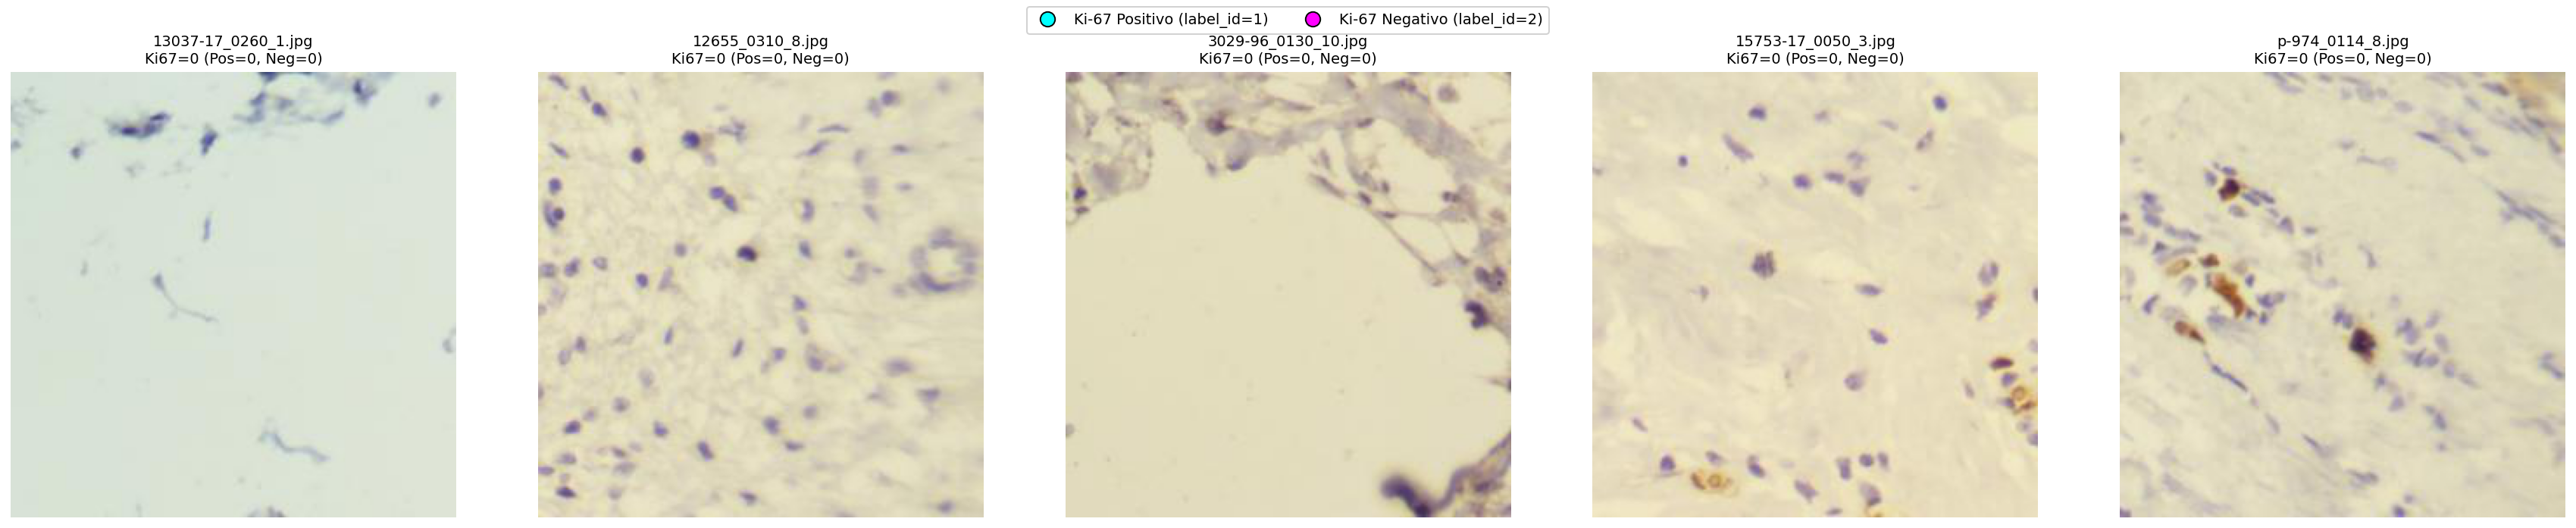

In [7]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

TEST_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/256x256 cropped images/test256")
N_SHOW = 5

COLOR_POS = "#00FFFF"  
COLOR_NEG = "#FF00FF" 

def load_points_shidc(json_path: Path):
    """
    JSON esperado:
    [
      {"x": int, "y": int, "label_id": 1|2|3},
      ...
    ]
    label_id: 1=Positive, 2=Negative, 3=TIL

    Retorna:
      pos (Nx2), neg (Mx2), til (Kx2) en formato (x,y)
    """
    if not json_path.exists():
        return (
            np.empty((0, 2), dtype=np.float32),
            np.empty((0, 2), dtype=np.float32),
            np.empty((0, 2), dtype=np.float32),
        )

    try:
        with open(json_path, "r") as f:
            data = json.load(f)

        if not isinstance(data, list):
            return (
                np.empty((0, 2), dtype=np.float32),
                np.empty((0, 2), dtype=np.float32),
                np.empty((0, 2), dtype=np.float32),
            )

        pos, neg, til = [], [], []
        for pt in data:
            if not all(k in pt for k in ("x", "y", "label_id")):
                continue

            x, y = float(pt["x"]), float(pt["y"])
            lab = pt["label_id"]

            if lab == 1:
                pos.append([x, y])
            elif lab == 2:
                neg.append([x, y])
            elif lab == 3:
                til.append([x, y])

        return (
            np.array(pos, dtype=np.float32),
            np.array(neg, dtype=np.float32),
            np.array(til, dtype=np.float32),
        )

    except Exception:
        return (
            np.empty((0, 2), dtype=np.float32),
            np.empty((0, 2), dtype=np.float32),
            np.empty((0, 2), dtype=np.float32),
        )


image_paths = sorted(list(TEST_DIR.glob("*.jpg")) + list(TEST_DIR.glob("*.png")))
if not image_paths:
    raise RuntimeError(f"No se encontraron imágenes en {TEST_DIR}")

stats = []
n_zero_ki67 = 0
n_json_missing = 0

for img_path in image_paths:
    json_path = img_path.with_suffix(".json")

    if not json_path.exists():
        n_json_missing += 1

    pos, neg, til = load_points_shidc(json_path)
    n_ki67 = int(len(pos) + len(neg))

    if n_ki67 == 0:
        n_zero_ki67 += 1

    stats.append({
        "img_path": img_path,
        "json_path": json_path,
        "n_pos": int(len(pos)),
        "n_neg": int(len(neg)),
        "n_til": int(len(til)),
        "n_ki67": n_ki67,
        "pos": pos,
        "neg": neg
    })

print("\nDATASET SHIDC – RESUMEN GT (Ki-67)")
print(f"Total imágenes analizadas        : {len(stats)}")
print(f"JSON faltantes                  : {n_json_missing}")
print(f"Imágenes con 0 Ki-67 anotados   : {n_zero_ki67}")
print(f"% sin Ki-67 (sobre total imgs)  : {(n_zero_ki67 / len(stats)) * 100:.2f}%")

min_ki67 = min(d["n_ki67"] for d in stats)
candidatas = [d for d in stats if d["n_ki67"] == min_ki67]

random.seed(42) 
if len(candidatas) > N_SHOW:
    top = random.sample(candidatas, N_SHOW)
else:
    top = candidatas

print("\nImágenes con MENOS biomarcadores Ki-67 (pos+neg)")
print(f"Empate mínimo Ki-67 = {min_ki67}")
print(f"Total imágenes empatadas = {len(candidatas)}\n")

for i, d in enumerate(top, 1):
    print(
        f"{i}. {d['img_path'].name} | "
        f"Ki67={d['n_ki67']} "
        f"(Pos={d['n_pos']}, Neg={d['n_neg']}, TIL={d['n_til']}) | "
        f"JSON={'OK' if d['json_path'].exists() else 'MISSING'}"
    )

cols = len(top)
fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5), dpi=140)

if cols == 1:
    axes = [axes]

for ax, d in zip(axes, top):
    img = Image.open(d["img_path"]).convert("RGB")
    ax.imshow(img)

    if d["n_pos"] > 0:
        ax.scatter(
            d["pos"][:, 0], d["pos"][:, 1],
            s=40, c=COLOR_POS,
            edgecolors="black", linewidths=0.4,
            alpha=0.9
        )

    if d["n_neg"] > 0:
        ax.scatter(
            d["neg"][:, 0], d["neg"][:, 1],
            s=40, c=COLOR_NEG,
            edgecolors="black", linewidths=0.4,
            alpha=0.9
        )

    ax.set_title(
        f"{d['img_path'].name}\n"
        f"Ki67={d['n_ki67']} (Pos={d['n_pos']}, Neg={d['n_neg']})",
        fontsize=10
    )
    ax.axis("off")

handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=COLOR_POS, markeredgecolor='black',
               markersize=10, label='Ki-67 Positivo (label_id=1)'),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=COLOR_NEG, markeredgecolor='black',
               markersize=10, label='Ki-67 Negativo (label_id=2)')
]
fig.legend(handles=handles, loc="upper center", ncol=2, framealpha=0.9)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


Imágenes con más FP

In [5]:


import os, json, contextlib, logging, warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple

import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from skimage.measure import regionprops

from cellpose import models as cp_models, io as cp_io

IDX_TO_CLASS = {0: "background", 1: "ki67_neg", 2: "ki67_pos"} 
GT_MAP = {1: "ki67_pos", 2: "ki67_neg"}                      

THRESHOLD = 0.82
PATCH_SIZE = 19
BATCH_INFER = 32
NUM_WORKERS = 0

TEST_IMG_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/256x256 cropped images/test256")
TEST_GT_DIR  = TEST_IMG_DIR

CKPT_PATH = Path("/media/HDD2/SHIDC_Training_Compare_SD/convnext_tiny_lr5e-05_wd0.0001_bs32/best_f1posneg.pth")

CELLPOSE_MODEL_TYPE = "cpsam"
CELLPOSE_DIAMETER = 15
CELLPOSE_INVERT = True
CELLPOSE_CELLPROB_THRESHOLD = -1.0
CELLPOSE_FLOW_THRESHOLD = 0.8
CELLPOSE_MIN_SIZE = 5


def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_checkpoint_state_dict(ckpt_path: Path, device: torch.device) -> Dict[str, torch.Tensor]:
    ckpt = torch.load(str(ckpt_path), map_location=device)
    if isinstance(ckpt, dict) and "model" in ckpt and isinstance(ckpt["model"], dict):
        return ckpt["model"]
    if isinstance(ckpt, dict) and "state_dict" in ckpt and isinstance(ckpt["state_dict"], dict):
        return ckpt["state_dict"]
    if isinstance(ckpt, dict):
        return ckpt
    raise RuntimeError(f"No pude inferir state_dict desde: {ckpt_path}")

def build_convnext_tiny(num_classes: int, device: torch.device):
    m = models.convnext_tiny(weights=None)
    in_features = m.classifier[2].in_features
    m.classifier[2] = nn.Linear(in_features, num_classes)
    return m.to(device)

class PatchDataset(Dataset):
    def __init__(self, patches_bgr: List[np.ndarray]):
        self.patches = patches_bgr
        self.tf = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    def __len__(self): return len(self.patches)

    def __getitem__(self, idx):
        bgr = self.patches[idx]
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        return self.tf(rgb)

def get_smart_patch(img_bgr: np.ndarray, cx: float, cy: float, size: int) -> np.ndarray:
    h, w = img_bgr.shape[:2]
    half = size // 2
    x1, y1 = int(round(cx - half)), int(round(cy - half))
    x2, y2 = x1 + size, y1 + size

    pad_l, pad_t = max(0, -x1), max(0, -y1)
    pad_r, pad_b = max(0, x2 - w), max(0, y2 - h)

    crop_x1, crop_y1 = max(0, x1), max(0, y1)
    crop_x2, crop_y2 = min(w, x2), min(h, y2)

    patch = img_bgr[crop_y1:crop_y2, crop_x1:crop_x2]
    if pad_l or pad_t or pad_r or pad_b:
        patch = cv2.copyMakeBorder(
            patch, pad_t, pad_b, pad_l, pad_r, borderType=cv2.BORDER_REFLECT
        )
    return patch

def load_gt_shidc_points_json(img_path: Path) -> List[dict]:
    """
    SHIDC: JSON al lado de la imagen, mismo nombre base.
    Formato:
      [{"x":..., "y":..., "label_id": 1|2|3}, ...]
    """
    json_path = img_path.with_suffix(".json")
    if not json_path.exists():
        return []
    try:
        with open(json_path, "r") as f:
            data = json.load(f)
        if not isinstance(data, list):
            return []
        out = []
        for pt in data:
            if not isinstance(pt, dict):
                continue
            if "x" not in pt or "y" not in pt:
                continue
            out.append({
                "x": float(pt["x"]),
                "y": float(pt["y"]),
                "label_id": int(pt.get("label_id", 0))
            })
        return out
    except Exception:
        return []

@dataclass
class ImageArtifacts:
    img_path: Path
    img_rgb: np.ndarray
    img_bgr: np.ndarray
    masks: np.ndarray
    cand_xy_maskid: List[Tuple[float, float, int]]
    patches_bgr: List[np.ndarray]
    gt_points: List[dict]

def segment_and_extract(img_path: Path, cellpose_model, patch_size: int, cp_eval_params: dict) -> ImageArtifacts:
    img_rgb = cp_io.imread(str(img_path))
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    gt_points = load_gt_shidc_points_json(img_path)

    masks, _, _ = cellpose_model.eval(img_rgb, **cp_eval_params)
    props = regionprops(masks)

    patches, cand = [], []
    for p in props:
        cy, cx = p.centroid
        patches.append(get_smart_patch(img_bgr, cx, cy, patch_size))
        cand.append((float(cx), float(cy), int(p.label)))

    return ImageArtifacts(
        img_path=img_path,
        img_rgb=img_rgb,
        img_bgr=img_bgr,
        masks=masks,
        cand_xy_maskid=cand,
        patches_bgr=patches,
        gt_points=gt_points
    )

def infer_probs_for_patches(model: nn.Module, patches_bgr: List[np.ndarray], device: torch.device,
                            batch_size: int, num_workers: int = 0) -> np.ndarray:
    if len(patches_bgr) == 0:
        return np.zeros((0, 3), dtype=np.float32)

    ds = PatchDataset(patches_bgr)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    probs = []
    use_cuda = (device.type == "cuda")
    amp_device = "cuda" if use_cuda else "cpu"

    model.eval()
    with torch.no_grad():
        for batch in dl:
            batch = batch.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=amp_device, enabled=use_cuda):
                logits = model(batch)
                p = F.softmax(logits, dim=1).float().detach().cpu().numpy()
            probs.append(p)

    return np.concatenate(probs, axis=0)

def apply_threshold_rule(probs: np.ndarray, thr: float) -> np.ndarray:
    if probs.shape[0] == 0:
        return np.zeros((0,), dtype=np.int64)

    p_bg = probs[:, 0]
    p_neg = probs[:, 1]
    p_pos = probs[:, 2]

    pred = np.where(
        p_bg > thr,
        0,
        np.where(p_pos > p_neg, 2, 1)
    ).astype(np.int64)
    return pred

def collect_fp_points(
    image_name: str,
    masks: np.ndarray,
    cand_xy_maskid: List[Tuple[float, float, int]],
    pred_idx: np.ndarray,
    gt_points: List[dict],
    idx_to_class: Dict[int, str],
    gt_map: Dict[int, str],
    threshold: float,
) -> Tuple[Dict[str, int], List[dict]]:
    """
    Devuelve:
      - summary: {"fp_pos": int, "fp_neg": int}
      - fp_points: lista de dicts con:
          image, x, y, pred_class, reason, mask_id, threshold
        reason:
          - "no_gt_in_mask": no hubo GT pos/neg dentro de esa máscara
          - "wrong_class": hubo GT en máscara, pero clase distinta
    """
    fp_pos = 0
    fp_neg = 0
    fp_points: List[dict] = []

    # Solo consideramos GT pos/neg para matching (ignoramos TIL)
    # y mantenemos un "used" para no matchear el mismo GT dos veces.
    gt_used = [False] * len(gt_points)

    for i, pidx in enumerate(pred_idx):
        pred_cls = idx_to_class[int(pidx)]
        cx, cy, mask_id = cand_xy_maskid[i]

        if pred_cls == "background":
            continue
        if pred_cls not in ("ki67_pos", "ki67_neg"):
            continue

        matched = False
        match_gt_cls = None

        for g_i, pt in enumerate(gt_points):
            if gt_used[g_i]:
                continue
            gt_cls = gt_map.get(int(pt["label_id"]), "unknown")
            if gt_cls not in ("ki67_pos", "ki67_neg"):
                continue

            gx, gy = float(pt["x"]), float(pt["y"])
            iy, ix = int(round(gy)), int(round(gx))
            if 0 <= iy < masks.shape[0] and 0 <= ix < masks.shape[1]:
                if int(masks[iy, ix]) == int(mask_id):
                    matched = True
                    gt_used[g_i] = True
                    match_gt_cls = gt_cls
                    break

        if not matched:
            if pred_cls == "ki67_pos":
                fp_pos += 1
            else:
                fp_neg += 1
            fp_points.append({
                "image": image_name,
                "x": float(cx),
                "y": float(cy),
                "pred_class": pred_cls,
                "reason": "no_gt_in_mask",
                "mask_id": int(mask_id),
                "threshold": float(threshold),
            })
        else:
            if pred_cls != match_gt_cls:
                if pred_cls == "ki67_pos":
                    fp_pos += 1
                else:
                    fp_neg += 1
                fp_points.append({
                    "image": image_name,
                    "x": float(cx),
                    "y": float(cy),
                    "pred_class": pred_cls,
                    "reason": "wrong_class",
                    "mask_id": int(mask_id),
                    "threshold": float(threshold),
                })

    return {"fp_pos": fp_pos, "fp_neg": fp_neg}, fp_points

set_seed(42)

warnings.filterwarnings("ignore")
cp_io.logger_setup()
logging.getLogger("cellpose").setLevel(logging.CRITICAL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

img_files = sorted(list(TEST_IMG_DIR.glob("*.png")) + list(TEST_IMG_DIR.glob("*.jpg")))
if not img_files:
    raise FileNotFoundError(f"No hay imágenes en {TEST_IMG_DIR}")

print("Cargando Cellpose...")
cp = cp_models.CellposeModel(gpu=torch.cuda.is_available(), pretrained_model=CELLPOSE_MODEL_TYPE)
cp_eval_params = dict(
    diameter=CELLPOSE_DIAMETER,
    invert=bool(CELLPOSE_INVERT),
    cellprob_threshold=CELLPOSE_CELLPROB_THRESHOLD,
    flow_threshold=CELLPOSE_FLOW_THRESHOLD,
    min_size=CELLPOSE_MIN_SIZE
)

print("Cargando ConvNeXt...")
convnext = build_convnext_tiny(num_classes=3, device=device)
sd = load_checkpoint_state_dict(CKPT_PATH, device=device)
convnext.load_state_dict(sd, strict=True)
convnext.eval()

rows_image = []
rows_fp_points = []

for ip in tqdm(img_files, desc="Infer + FP export"):
    art = segment_and_extract(
        img_path=ip,
        cellpose_model=cp,
        patch_size=PATCH_SIZE,
        cp_eval_params=cp_eval_params
    )

    probs = infer_probs_for_patches(
        model=convnext,
        patches_bgr=art.patches_bgr,
        device=device,
        batch_size=BATCH_INFER,
        num_workers=NUM_WORKERS
    )
    pred_idx = apply_threshold_rule(probs, THRESHOLD)

    fp_counts, fp_points = collect_fp_points(
        image_name=ip.name,
        masks=art.masks,
        cand_xy_maskid=art.cand_xy_maskid,
        pred_idx=pred_idx,
        gt_points=art.gt_points,
        idx_to_class=IDX_TO_CLASS,
        gt_map=GT_MAP,
        threshold=THRESHOLD,
    )

    rows_image.append({
        "image": ip.name,
        "fp_pos": fp_counts["fp_pos"],
        "fp_neg": fp_counts["fp_neg"],
        "n_candidates": len(art.cand_xy_maskid),
        "n_gt_points_total": len(art.gt_points),
        "threshold": THRESHOLD
    })

    rows_fp_points.extend(fp_points)

df_img = pd.DataFrame(rows_image)
df_fp = pd.DataFrame(rows_fp_points)

top5_fp_pos = df_img.sort_values("fp_pos", ascending=False).head(5)
top5_fp_neg = df_img.sort_values("fp_neg", ascending=False).head(5)

print("\nTOP 5 imágenes con MÁS FP ki67_pos (thr=0.82):")
print(top5_fp_pos[["image", "fp_pos", "fp_neg", "n_candidates", "n_gt_points_total"]].to_string(index=False))

print("\nTOP 5 imágenes con MÁS FP ki67_neg (thr=0.82):")
print(top5_fp_neg[["image", "fp_neg", "fp_pos", "n_candidates", "n_gt_points_total"]].to_string(index=False))

# Guardar CSVs
out_csv_img = Path("./fp_by_image_convnext_thr082.csv")
out_csv_fp  = Path("./fp_points_convnext_thr082.csv")

df_img.to_csv(out_csv_img, index=False)
df_fp.to_csv(out_csv_fp, index=False)

print(f"\nGuardado resumen por imagen: {out_csv_img}")
print(f"Guardado FP puntuales      : {out_csv_fp}")
print(f"Total FP puntuales exportados : {len(df_fp)}")


Device: cuda
🦠 Cargando Cellpose...
🧠 Cargando ConvNeXt...


Infer + FP export:   0%|          | 0/700 [00:00<?, ?it/s]


🔥 TOP 5 imágenes con MÁS FP ki67_pos (thr=0.82):
               image  fp_pos  fp_neg  n_candidates  n_gt_points_total
 14985-17_0030_7.jpg      46      14           246                150
 14985-17_0030_3.jpg      44       5           244                131
 14985-17_0016_5.jpg      44      25           291                175
14985-17_0023_10.jpg      43      14           220                131
 14985-17_0023_7.jpg      41      20           214                130

🔥 TOP 5 imágenes con MÁS FP ki67_neg (thr=0.82):
              image  fp_neg  fp_pos  n_candidates  n_gt_points_total
   p-974_0115_7.jpg     291      10           403                 23
  12655_0299_10.jpg     202      22           311                223
SC-12675_0009_7.jpg     180      12           318                 92
   p-974_0113_3.jpg     145       6           226                 14
SC-12675_0025_3.jpg     119       6           204                 29

✅ Guardado resumen por imagen: fp_by_image_convnext_thr082.csv
✅ 

image  fp_pos  fp_neg  n_candidates  n_gt_points_total  \
0   14985-17_0030_7.jpg      46      14           246                150   
1   14985-17_0030_3.jpg      44       5           244                131   
2   14985-17_0016_5.jpg      44      25           291                175   
3  14985-17_0023_10.jpg      43      14           220                131   
4   14985-17_0023_7.jpg      41      20           214                130   

   threshold  
0       0.82  
1       0.82  
2       0.82  
3       0.82  
4       0.82

image  fp_pos  fp_neg  n_candidates  n_gt_points_total  \
0     p-974_0115_7.jpg      10     291           403                 23   
1    12655_0299_10.jpg      22     202           311                223   
2  SC-12675_0009_7.jpg      12     180           318                 92   
3     p-974_0113_3.jpg       6     145           226                 14   
4  SC-12675_0025_3.jpg       6     119           204                 29   

   threshold  
0       0.82  
1       0.82  
2       0.82  
3       0.82  
4       0.82

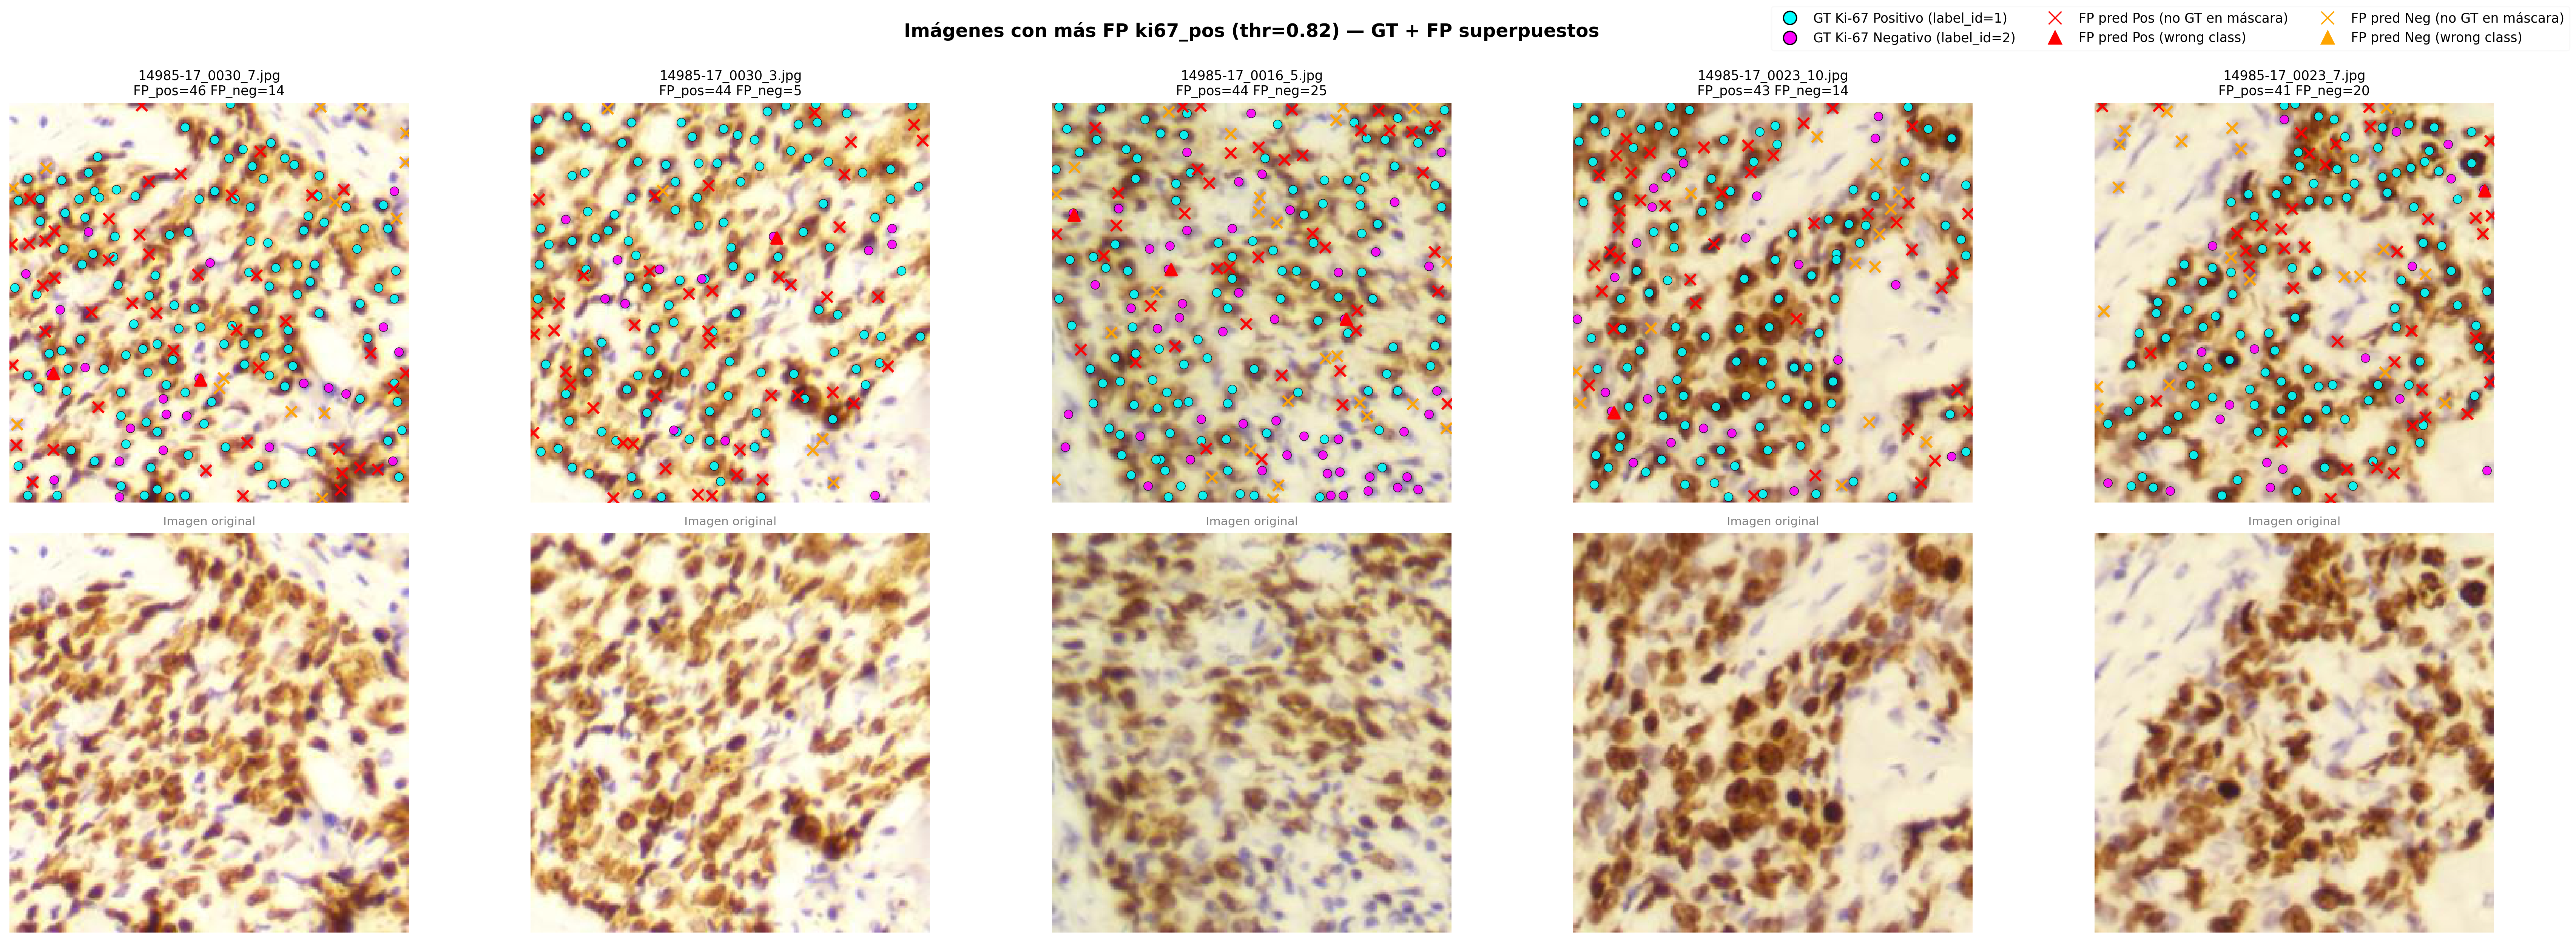

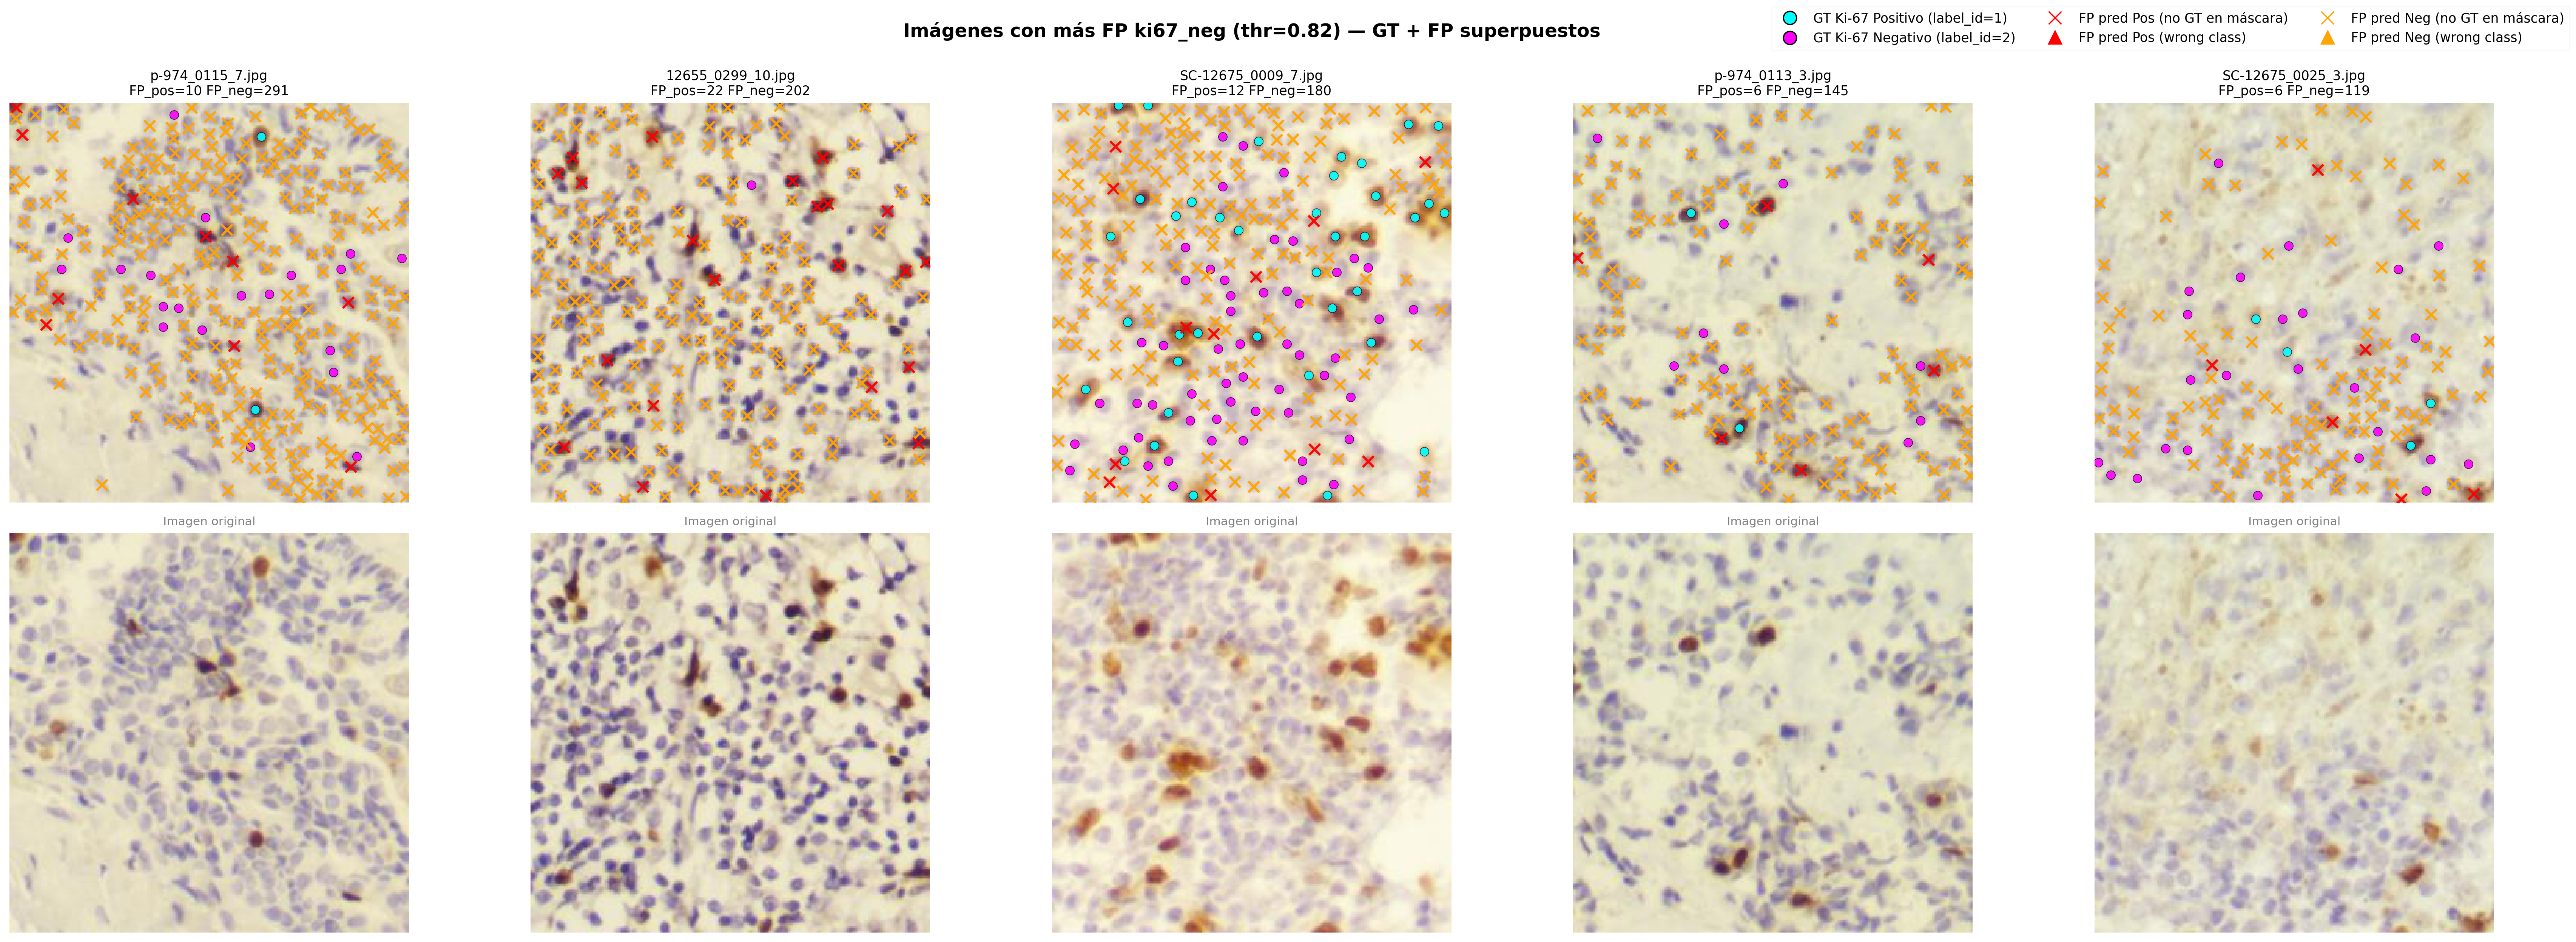

In [24]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


TEST_IMG_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/256x256 cropped images/test256")

CSV_SUMMARY = Path("./fp_by_image_convnext_thr082.csv")  
CSV_FPPTS   = Path("./fp_points_convnext_thr082.csv")      


COLOR_POS = "#00FFFF"  
COLOR_NEG = "#FF00FF"  


COLOR_FP_POS = "#FF0000" 
COLOR_FP_NEG = "#FFA500" 

df = pd.read_csv(CSV_SUMMARY)
df_fp = pd.read_csv(CSV_FPPTS)

top5_fp_pos = df.sort_values("fp_pos", ascending=False).head(5).reset_index(drop=True)
top5_fp_neg = df.sort_values("fp_neg", ascending=False).head(5).reset_index(drop=True)

display(top5_fp_pos)
display(top5_fp_neg)


def load_gt_shidc(json_path: Path):
    """
    JSON SHIDC:
    [{"x": int, "y": int, "label_id": 1|2|3}, ...]
    label_id: 1=ki67_pos, 2=ki67_neg, 3=TIL (ignoramos TIL)
    """
    if not json_path.exists():
        return np.empty((0, 2)), np.empty((0, 2))

    try:
        with open(json_path, "r") as f:
            data = json.load(f)
        if not isinstance(data, list):
            return np.empty((0, 2)), np.empty((0, 2))

        pos, neg = [], []
        for pt in data:
            if not all(k in pt for k in ("x", "y", "label_id")):
                continue
            x, y = float(pt["x"]), float(pt["y"])
            if pt["label_id"] == 1:
                pos.append([x, y])
            elif pt["label_id"] == 2:
                neg.append([x, y])

        return np.array(pos), np.array(neg)

    except Exception:
        return np.empty((0, 2)), np.empty((0, 2))


def show_images_with_gt_and_fp(image_names, title, ncols=5):
    """
    Fila superior: imagen + GT + FP
    Fila inferior: imagen sola
    Leyenda a la DERECHA
    """
    n = len(image_names)
    ncols = min(ncols, n)

    nrows = 2 * int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(5 * ncols + 3, 5 * nrows),
        dpi=250
    )

    fig.suptitle(title, fontsize=14, fontweight="bold")

    for i, img_name in enumerate(image_names):
        col = i % ncols
        row_overlay = 2 * (i // ncols)
        row_clean   = row_overlay + 1

        ax_overlay = axes[row_overlay, col]
        ax_clean   = axes[row_clean, col]

        for ax in (ax_overlay, ax_clean):
            ax.axis("off")

        img_path = TEST_IMG_DIR / img_name
        json_path = img_path.with_suffix(".json")

        if not img_path.exists():
            ax_overlay.text(0.5, 0.5, "NO ENCONTRADA", ha="center", va="center")
            ax_clean.text(0.5, 0.5, "NO ENCONTRADA", ha="center", va="center")
            continue

        img = Image.open(img_path).convert("RGB")
        ax_overlay.imshow(img)

        pos, neg = load_gt_shidc(json_path)
        if len(pos) > 0:
            ax_overlay.scatter(
                pos[:, 0], pos[:, 1],
                s=45, c=COLOR_POS,
                edgecolors="black", linewidths=0.4,
                alpha=0.9
            )
        if len(neg) > 0:
            ax_overlay.scatter(
                neg[:, 0], neg[:, 1],
                s=45, c=COLOR_NEG,
                edgecolors="black", linewidths=0.4,
                alpha=0.9
            )
        sub_fp = df_fp[df_fp["image"] == img_name]

        def plot_fp(df_sub, color):
            for reason, marker in [("no_gt_in_mask", "x"), ("wrong_class", "^")]:
                dfr = df_sub[df_sub["reason"] == reason]
                if dfr.empty:
                    continue
                ax_overlay.scatter(
                    dfr["x"], dfr["y"],
                    s=70,
                    c=color,
                    marker=marker,
                    linewidths=1.8,
                    alpha=0.95
                )

        plot_fp(sub_fp[sub_fp["pred_class"] == "ki67_pos"], COLOR_FP_POS)
        plot_fp(sub_fp[sub_fp["pred_class"] == "ki67_neg"], COLOR_FP_NEG)

        ax_overlay.set_title(
            f"{img_name}\nFP_pos={len(sub_fp[sub_fp.pred_class=='ki67_pos'])} "
            f"FP_neg={len(sub_fp[sub_fp.pred_class=='ki67_neg'])}",
            fontsize=10
        )
        ax_clean.imshow(img)
        ax_clean.set_title("Imagen original", fontsize=9, color="gray")

    handles = [

        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=COLOR_POS, markeredgecolor='black',
                   markersize=10, label='GT Ki-67 Positivo (label_id=1)'),
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=COLOR_NEG, markeredgecolor='black',
                   markersize=10, label='GT Ki-67 Negativo (label_id=2)'),

        plt.Line2D([0], [0], marker='x', color=COLOR_FP_POS,
                   markersize=10, linestyle='None', label='FP pred Pos (no GT en máscara)'),
        plt.Line2D([0], [0], marker='^', color=COLOR_FP_POS,
                   markersize=10, linestyle='None', label='FP pred Pos (wrong class)'),

        plt.Line2D([0], [0], marker='x', color=COLOR_FP_NEG,
                   markersize=10, linestyle='None', label='FP pred Neg (no GT en máscara)'),
        plt.Line2D([0], [0], marker='^', color=COLOR_FP_NEG,
                   markersize=10, linestyle='None', label='FP pred Neg (wrong class)'),
    ]
    fig.legend(handles=handles, loc="upper right", ncol=3, framealpha=0.1)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


show_images_with_gt_and_fp(
    top5_fp_pos["image"].tolist(),
    title="Imágenes con más FP ki67_pos (thr=0.82) — GT + FP superpuestos"
)

show_images_with_gt_and_fp(
    top5_fp_neg["image"].tolist(),
    title="Imágenes con más FP ki67_neg (thr=0.82) — GT + FP superpuestos"
)
